Basic imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random
import warnings
from glob import glob
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import base64
warnings.filterwarnings("ignore")
%matplotlib inline

Read csv file and image paths

In [35]:
IMAGE_ROOT = "/content/drive/MyDrive/input/bt_classifier/Multi_Label_dataset/train"
CSV_PATH = "/content/drive/MyDrive/input/bt_classifier/Multi_Label_dataset/train_updated_2_missing_value_modify.csv"

df = pd.read_csv(CSV_PATH)
image_paths = glob(IMAGE_ROOT + os.sep + "*.jpg")

In [36]:
df

,Patient ID,IDH status,IDH-1P10Q Subtype,ATRX status,MGMT promoter status,TERT expression status,Cancer Type Detailed
0,0_0_TCGA-02-0006_BS1_001,0.0,0.0,1.0,0.0,0.0,G
1,0_0_TCGA-02-0007_BS1_001,0.0,0.0,1.0,0.0,0.0,G
2,0_0_TCGA-02-0010_BS1_001,1.0,0.0,1.0,0.0,0.0,G
3,0_0_TCGA-02-0010_BS1_001_3,1.0,0.0,1.0,0.0,0.0,G
4,0_0_TCGA-02-0016_BS1_001,0.0,0.0,1.0,1.0,0.0,G
...,...,...,...,...,...,...,...
6055,7_2_TCGA-HT-7603_BS1_001_3,1.0,0.0,1.0,1.0,0.0,O
6056,7_2_TCGA-HT-7605_BS1_001_3,1.0,1.0,0.0,1.0,0.0,O
6057,7_2_TCGA-HT-7616_BS1_001_3,1.0,1.0,0.0,1.0,0.0,O
6058,7_2_TCGA-HT-7677_BS1_001_3,1.0,1.0,0.0,1.0,1.0,O


## Deep Learning

### Dataset class creation

In [37]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [38]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['Patient ID']
        self.all_labels = np.array(self.csv.drop(['Patient ID','Cancer Type Detailed'], axis=1))
        self.train_ratio = int(0.70 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        # set the training data images and labels
        if self.train:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:-10])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(f"/content/drive/MyDrive/input/bt_classifier/Multi_Label_dataset/train/{self.image_names[index]}.jpg")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

### Model creation
We use the EfficientNet-B0 model architecture

In [39]:
import torchvision.models as models
import torch.nn as nn

def build_model(pretrained=False, fine_tune=True, num_classes=5):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b0(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

### Custom Loss Function

In [40]:
# Finding number of positive and negative samples in each label 

N = len(df) 

labels = df.keys()[1:-1]

for k, label in enumerate(sorted(labels)):
    positives = sum(df[label] == 1)
    print(
      '{}:\tPositive Samples: {}\t\tNegative Samples: {}'
      .format(label, positives, N - positives)
    )

ATRX status:	Positive Samples: 3138		Negative Samples: 2922
IDH status:	Positive Samples: 3809		Negative Samples: 2251
IDH-1P10Q Subtype:	Positive Samples: 2000		Negative Samples: 4060
MGMT promoter status:	Positive Samples: 4905		Negative Samples: 1155
TERT expression status:	Positive Samples: 1940		Negative Samples: 4120


In [41]:
# Calculating class weights for each label

class_weights = {}
positive_weights = {}
negative_weights = {}

for label in sorted(labels):
    positive_weights[label] = N /(2 * sum(df[label] == 1))
    negative_weights[label] = N /(2 * sum(df[label] == 0))
    
class_weights['positive_weights'] = positive_weights
class_weights['negative_weights'] = negative_weights

class_weights

{'positive_weights': {'ATRX status': 0.9655831739961759,
  'IDH status': 0.7954843791021265,
  'IDH-1P10Q Subtype': 1.515,
  'MGMT promoter status': 0.617737003058104,
  'TERT expression status': 1.5618556701030928},
 'negative_weights': {'ATRX status': 1.0369609856262834,
  'IDH status': 1.3460684140382053,
  'IDH-1P10Q Subtype': 0.7463054187192119,
  'MGMT promoter status': 2.6233766233766236,
  'TERT expression status': 0.7354368932038835}}

In [42]:
import torch
import torch.nn.functional as F

Wp = class_weights['positive_weights']
Wn = class_weights['negative_weights']

def custom_loss(y_true, y_pred):
    '''
    Multi-label cross-entropy
    * Required "Wp", "Wn" as positive & negative class-weights
    y_true: true value
    y_pred: predicted value
    '''
    loss = 0.0

    for i, key in enumerate(Wp.keys()):
        first_term = Wp[key] * y_true[:, i] * torch.log(y_pred[:, i] + 1e-7)
        second_term = Wn[key] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + 1e-7)
        loss -= torch.sum(first_term + second_term)
    
    return loss

### Create train function

In [43]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    targets = []
    predictions = []
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data) / dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        binarized_outputs = torch.round(outputs)
        # binarized_outputs.requires_grad = True
        # binarized_outputs.retain_grad()
        # print("GT: ", target)
        # print("Prediction: ", binarized_outputs)
        # print(binarized_outputs.grad_fn)
        # print(binarized_outputs.requires_grad)
        loss = custom_loss(target, binarized_outputs)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        y_true = target.detach().cpu().numpy()
        y_pred = binarized_outputs.detach().cpu().numpy()
        # confustion_matrix = multilabel_confusion_matrix(y_true, y_pred)
        # print(confustion_matrix)
        # print(classification_report(y_true, y_pred))
        targets.append(y_true)
        predictions.append(y_pred)
    targets = np.concatenate(targets)
    predictions = np.concatenate(predictions)
    train_loss = train_running_loss / counter
    return train_loss, targets, predictions

### Create validation function

In [44]:
# validation function
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    targets = []
    predictions = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            binarized_outputs = torch.round(outputs)
            loss = custom_loss(target, binarized_outputs)
            val_running_loss += loss.item()
            y_true = target.detach().cpu().numpy()
            y_pred = binarized_outputs.detach().cpu().numpy()
            targets.append(y_true)
            predictions.append(y_pred)
        val_loss = val_running_loss / counter
        targets = np.concatenate(targets)
        predictions = np.concatenate(predictions)
        return val_loss, targets, predictions

### Initiate model and start training

In [45]:
import torch.optim as optim
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
#intialize the model
model = build_model(pretrained=False, fine_tune=True, num_classes=5).to(device)
# learning parameters
lr = 1e-3
epochs = 30
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
# criterion = nn.BCELoss()

[INFO]: Not loading pre-trained weights
[INFO]: Fine-tuning all layers...


In [47]:
# train dataset
train_data = ImageDataset(df, train=True, test=False)
# validation dataset
valid_data = ImageDataset(df, train=False, test=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

Number of training images: 4242
Number of validation images: 1818


### Defining Example Based metrics
Implementations are taken from [here](https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd)
1.  Exact Match Ration (EMR)

In [48]:
def emr(y_true, y_pred):
    n = len(y_true)
    row_indicators = np.all(y_true == y_pred, axis = 1) # axis = 1 will check for equality along rows.
    exact_match_count = np.sum(row_indicators)
    return exact_match_count/n

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
print("EMR: ", emr(gt, pred))

EMR:  0.4


2. 1/0 Loss

In [49]:
def one_zero_loss(y_true, y_pred):
    n = len(y_true)
    row_indicators = np.logical_not(np.all(y_true == y_pred, axis = 1)) # axis = 1 will check for equality along rows.
    not_equal_count = np.sum(row_indicators)
    return not_equal_count/n

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
print("1/0 Loss: ", one_zero_loss(gt, pred))

1/0 Loss:  0.6


3. Hamming Loss

In [50]:
def hamming_loss(y_true, y_pred):
    """
	XOR TT for reference -

	A  B   Output

	0  0    0
	0  1    1
	1  0    1
	1  1    0
	"""
    hl_num = np.sum(np.logical_xor(y_true, y_pred))
    hl_den = np.prod(y_true.shape)

    return hl_num/hl_den

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
hl_value = hamming_loss(gt, pred)
print(f"Hamming Loss: {hl_value}")

Hamming Loss: 0.2


4. Example based accuracy

In [51]:
def example_based_accuracy(y_true, y_pred):

    # compute true positives using the logical AND operator
    numerator = np.sum(np.logical_and(y_true, y_pred), axis = 1)

    # compute true_positive + false negatives + false positive using the logical OR operator
    denominator = np.sum(np.logical_or(y_true, y_pred), axis = 1)
    instance_accuracy = numerator/denominator

    avg_accuracy = np.mean(instance_accuracy)
    return avg_accuracy

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
ex_based_accuracy = example_based_accuracy(gt, pred)
print(f"Example Based Accuracy: {ex_based_accuracy}")

Example Based Accuracy: 0.7


5. Example-Based Precision

In [52]:
def example_based_precision(y_true, y_pred):
    """
    precision = TP/ (TP + FP)
    """

    # Compute True Positive
    precision_num = np.sum(np.logical_and(y_true, y_pred), axis = 1)

    # Total number of pred true labels
    precision_den = np.sum(y_pred, axis = 1)

    # precision averaged over all training examples
    avg_precision = np.mean(precision_num/precision_den)

    return avg_precision

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
ex_based_precision = example_based_precision(gt, pred)
print(f"Example Based Precision: {ex_based_precision}")

Example Based Precision: 0.8


### Defining Label based metrics
1. Macro Averaged Accuracy

In [53]:
def label_based_macro_accuracy(y_true, y_pred):

    # axis = 0 computes true positives along columns i.e labels
    l_acc_num = np.sum(np.logical_and(y_true, y_pred), axis = 0)

    # axis = 0 computes true postive + false positive + false negatives along columns i.e labels
    l_acc_den = np.sum(np.logical_or(y_true, y_pred), axis = 0)

    # compute mean accuracy across labels.
    return np.mean(l_acc_num/l_acc_den)
# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_macro_acc_val = label_based_macro_accuracy(gt, pred)
print(f"Label Based Macro Accuracy: {lb_macro_acc_val}")

Label Based Macro Accuracy: 0.7222222222222222


2. Macro Averaged Precision

In [54]:
def label_based_macro_precision(y_true, y_pred):
 
    # axis = 0 computes true positive along columns i.e labels
    l_prec_num = np.sum(np.logical_and(y_true, y_pred), axis = 0)

    # axis = computes true_positive + false positive along columns i.e labels
    l_prec_den = np.sum(y_pred, axis = 0)

    # compute precision per class/label
    l_prec_per_class = l_prec_num/l_prec_den

    # macro precision = average of precsion across labels. 
    l_prec = np.mean(l_prec_per_class)
    return l_prec

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_macro_precision_val = label_based_macro_precision(gt, pred)
print(f"Label Based Precision: {lb_macro_precision_val}")

Label Based Precision: 0.7777777777777777


3. Macro Averaged Recall

In [55]:
def label_based_macro_recall(y_true, y_pred):
    
    # compute true positive along axis = 0 i.e labels
    l_recall_num = np.sum(np.logical_and(y_true, y_pred), axis = 0)

    # compute true positive + false negatives along axis = 0 i.e columns
    l_recall_den = np.sum(y_true, axis = 0)

    # compute recall per class/label
    l_recall_per_class = l_recall_num/l_recall_den

    # compute macro averaged recall i.e recall averaged across labels. 
    l_recall = np.mean(l_recall_per_class)
    return l_recall

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_macro_recall_val = label_based_macro_recall(gt, pred) 
print(f"Label Based Recall: {lb_macro_recall_val}")

Label Based Recall: 0.8888888888888888


4. Micro Averaged Accuracy

In [56]:
def label_based_micro_accuracy(y_true, y_pred):
    
    # sum of all true positives across all examples and labels 
    l_acc_num = np.sum(np.logical_and(y_true, y_pred))

    # sum of all tp+fp+fn across all examples and labels.
    l_acc_den = np.sum(np.logical_or(y_true, y_pred))

    # compute mirco averaged accuracy
    return l_acc_num/l_acc_den

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_micro_acc_val = label_based_micro_accuracy(gt, pred)
print(f"Label Based Micro Accuracy: {lb_micro_acc_val}")

Label Based Micro Accuracy: 0.7272727272727273


5. Micro Averaged Precision

In [57]:
def label_based_micro_precision(y_true, y_pred):
    
    # compute sum of true positives (tp) across training examples
    # and labels. 
    l_prec_num = np.sum(np.logical_and(y_true, y_pred))

    # compute the sum of tp + fp across training examples and labels
    l_prec_den = np.sum(y_pred)

    # compute micro-averaged precision
    return l_prec_num/l_prec_den

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_micro_prec_val = label_based_micro_precision(gt, pred)
print(f"Label Based Micro Precision: {lb_micro_prec_val}")

Label Based Micro Precision: 0.8


6. Micro Averaged Recall

In [58]:
def label_based_micro_recall(y_true, y_pred):
	
    # compute sum of true positives across training examples and labels.
    l_recall_num = np.sum(np.logical_and(y_true, y_pred))
    # compute sum of tp + fn across training examples and labels
    l_recall_den = np.sum(y_true)

    # compute mirco-average recall
    return l_recall_num/l_recall_den

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_micro_recall_val = label_based_micro_recall(gt, pred)
print(f"Label Based Micro Recall: {lb_micro_recall_val}")

Label Based Micro Recall: 0.8888888888888888


### Defining F1 Score


In [59]:
import numpy as np

def f1_score(y_true, y_pred):
    '''
    Calculate F1 score
    y_true: true value
    y_pred: predicted value
    '''
    epsilon = 1e-7

    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + epsilon)
    predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + epsilon)
    return (2 * precision * recall) / (precision + recall + epsilon)

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
f1_score = f1_score(gt, pred)
print(f"F1 Score: {f1_score}")

F1 Score: 0.8421052044321361


Starting training and validation

In [60]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
# start the training and validation
emr_list = []
one_zero_loss_list = []
hamming_loss_list = []
example_based_accuracy_list = []
example_based_precision_list = []
label_based_macro_accuracy_list = []
label_based_macro_precision_list = []
label_based_macro_recall_list = []
label_based_micro_accuracy_list = []
label_based_micro_precision_list = []
label_based_micro_recall_list = []
# f1_score_list= []

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    print("Training...")
    train_epoch_loss, targets, predictions = train(
        model, train_loader, optimizer, custom_loss, train_data, device
    )
    print("Classification Report")
    print(classification_report(targets, predictions))
    
    emr_score = emr(targets, predictions)
    one_zero_loss_score = one_zero_loss(targets, predictions)
    hamming_loss_score = hamming_loss(targets, predictions)
    example_based_accuracy_score = example_based_accuracy(targets, predictions)
    example_based_precision_score = example_based_precision(targets, predictions)
    label_based_macro_accuracy_score = label_based_macro_accuracy(targets, predictions)
    label_based_macro_precision_score = label_based_macro_precision(targets, predictions)
    label_based_macro_recall_score = label_based_macro_recall(targets, predictions)
    label_based_micro_accuracy_score = label_based_micro_accuracy(targets, predictions)
    label_based_micro_precision_score = label_based_micro_precision(targets, predictions)
    label_based_micro_recall_score = label_based_micro_recall(targets, predictions)
    # f1_score = f1_score(targets, predictions)

    emr_list.append(emr_score)
    one_zero_loss_list.append(one_zero_loss_score)
    hamming_loss_list.append(hamming_loss_score)
    example_based_accuracy_list.append(example_based_accuracy_score)
    example_based_precision_list.append(example_based_precision_score)
    label_based_macro_accuracy_list.append(label_based_macro_accuracy_score)
    label_based_macro_precision_list.append(label_based_macro_precision_score)
    label_based_macro_recall_list.append(label_based_macro_recall_score)
    label_based_micro_accuracy_list.append(label_based_micro_accuracy_score)
    label_based_micro_precision_list.append(label_based_micro_precision_score)
    label_based_micro_recall_list.append(label_based_micro_recall_score)
    # f1_score_list.append(f1_score)

    print("Exact match ratio: ", emr_score)
    print("1/0 Loss: ", one_zero_loss_score)
    print("Hamming Loss: ", hamming_loss_score)
    print("Example based Accuracy: ", example_based_accuracy_score)
    print("Example based precision: ", example_based_precision_score)
    print("Macro Averaged Accuracy: ", label_based_macro_accuracy_score)
    print("Macro Averaged Precision: ", label_based_macro_precision_score)
    print("Macro Averaged Recall: ", label_based_macro_recall_score)
    print("Micro Averaged Accuracy: ", label_based_micro_accuracy_score)
    print("Micro Averaged Precision: ", label_based_micro_precision_score)
    print("Micro Averaged Recall: ", label_based_micro_recall_score)
    # print("F1 Score:", f1_score)

    print("Validating...")
    valid_epoch_loss, val_targets, val_predictions = validate(
        model, valid_loader, custom_loss, valid_data, device
    )
    print("Classification Report")
    print(classification_report(val_targets, val_predictions))
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 1 of 30
Training...
Training


133it [01:44,  1.27it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.28      0.37      2371
           1       0.26      0.51      0.34      1165
           2       0.59      0.91      0.71      2438
           3       0.82      0.29      0.43      3380
           4       0.25      0.29      0.27      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.49      0.45      0.42     10524
weighted avg       0.58      0.45      0.45     10524
 samples avg       0.48      0.46      0.43     10524

Exact match ratio:  0.02993870815652994
1/0 Loss:  0.97006129184347
Hamming Loss:  0.5077793493635078
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2830020868279071
Macro Averaged Precision:  0.4937658127611833
Macro Averaged Recall:  0.4548204374789738
Micro Averaged Accuracy:  0.3075736145043076
Micro Averaged Precision:  0.4874668840432036
Micro Averaged Recall:  0.4545800076016724
Valida

57it [00:23,  2.48it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1429
           1       0.46      0.14      0.21       828
           2       0.43      0.85      0.57       698
           3       0.84      0.16      0.27      1515
           4       0.39      0.13      0.20       765

   micro avg       0.62      0.42      0.50      5235
   macro avg       0.59      0.42      0.41      5235
weighted avg       0.66      0.42      0.44      5235
 samples avg       0.64      0.42      0.47      5235

Train Loss: 1278.3465
Val Loss: 1146.2513
Epoch 2 of 30
Training...
Training


133it [01:42,  1.30it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.28      0.38      2371
           1       0.26      0.51      0.34      1165
           2       0.59      0.91      0.71      2438
           3       0.83      0.30      0.44      3380
           4       0.24      0.29      0.27      1170

   micro avg       0.49      0.46      0.47     10524
   macro avg       0.50      0.46      0.43     10524
weighted avg       0.59      0.46      0.46     10524
 samples avg       0.48      0.46      0.43     10524

Exact match ratio:  0.025695426685525696
1/0 Loss:  0.9743045733144743
Hamming Loss:  0.506977840641207
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2859360934854154
Macro Averaged Precision:  0.49840456467420324
Macro Averaged Recall:  0.4593488166375863
Micro Averaged Accuracy:  0.3103072285292797
Micro Averaged Precision:  0.4884401817264008
Micro Averaged Recall:  0.459711136450019
Vali

57it [00:22,  2.52it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1429
           1       0.47      0.14      0.22       828
           2       0.44      0.80      0.57       698
           3       0.84      0.16      0.27      1515
           4       0.39      0.14      0.21       765

   micro avg       0.63      0.41      0.50      5235
   macro avg       0.59      0.41      0.42      5235
weighted avg       0.66      0.41      0.44      5235
 samples avg       0.65      0.41      0.46      5235

Train Loss: 1277.1653
Val Loss: 1150.4807
Epoch 3 of 30
Training...
Training


133it [01:41,  1.30it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.59      0.29      0.39      2371
           1       0.26      0.53      0.35      1165
           2       0.59      0.90      0.71      2438
           3       0.83      0.29      0.43      3380
           4       0.25      0.30      0.27      1170

   micro avg       0.49      0.46      0.48     10524
   macro avg       0.50      0.46      0.43     10524
weighted avg       0.59      0.46      0.46     10524
 samples avg       0.48      0.46      0.43     10524

Exact match ratio:  0.02428099952852428
1/0 Loss:  0.9757190004714758
Hamming Loss:  0.5031117397454031
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2883931239499899
Macro Averaged Precision:  0.5035147876373681
Macro Averaged Recall:  0.46224645682786303
Micro Averaged Accuracy:  0.31212531425256235
Micro Averaged Precision:  0.492523649679585
Micro Averaged Recall:  0.4600912200684151
Val

57it [00:23,  2.46it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1429
           1       0.47      0.13      0.20       828
           2       0.44      0.75      0.55       698
           3       0.84      0.16      0.26      1515
           4       0.39      0.13      0.19       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.40      0.41      5235
weighted avg       0.66      0.41      0.44      5235
 samples avg       0.67      0.41      0.46      5235

Train Loss: 1268.1791
Val Loss: 1141.6716
Epoch 4 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.30      0.39      2371
           1       0.25      0.49      0.33      1165
           2       0.59      0.92      0.72      2438
           3       0.83      0.28      0.42      3380
           4       0.25      0.28      0.26      1170

   micro avg       0.49      0.46      0.47     10524
   macro avg       0.50      0.45      0.43     10524
weighted avg       0.59      0.46      0.46     10524
 samples avg       0.49      0.46      0.43     10524

Exact match ratio:  0.026402640264026403
1/0 Loss:  0.9735973597359736
Hamming Loss:  0.5044318717586044
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2850131989408203
Macro Averaged Precision:  0.496669452759364
Macro Averaged Recall:  0.4549728510600685
Micro Averaged Accuracy:  0.309964527571751
Micro Averaged Precision:  0.491059568815776
Micro Averaged Recall:  0.4566704675028506
Valida

57it [00:23,  2.46it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1429
           1       0.47      0.13      0.20       828
           2       0.44      0.77      0.56       698
           3       0.84      0.15      0.25      1515
           4       0.38      0.13      0.19       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.59      0.40      0.41      5235
weighted avg       0.66      0.41      0.44      5235
 samples avg       0.67      0.41      0.46      5235

Train Loss: 1263.1714
Val Loss: 1137.4964
Epoch 5 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.29      0.38      2371
           1       0.26      0.50      0.34      1165
           2       0.59      0.90      0.71      2438
           3       0.81      0.28      0.41      3380
           4       0.23      0.25      0.24      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.49      0.44      0.42     10524
weighted avg       0.58      0.45      0.45     10524
 samples avg       0.48      0.44      0.42     10524

Exact match ratio:  0.029231494578029232
1/0 Loss:  0.9707685054219708
Hamming Loss:  0.508015087223008
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2778082069129545
Macro Averaged Precision:  0.49013850437551343
Macro Averaged Recall:  0.44291338848710826
Micro Averaged Accuracy:  0.3031302548182641
Micro Averaged Precision:  0.486961038961039
Micro Averaged Recall:  0.4453629798555682
Val

57it [00:23,  2.47it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1429
           1       0.46      0.14      0.21       828
           2       0.42      0.65      0.51       698
           3       0.84      0.17      0.28      1515
           4       0.39      0.14      0.21       765

   micro avg       0.63      0.40      0.49      5235
   macro avg       0.59      0.38      0.41      5235
weighted avg       0.66      0.40      0.44      5235
 samples avg       0.67      0.39      0.45      5235

Train Loss: 1279.5106
Val Loss: 1173.2638
Epoch 6 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.55      0.29      0.38      2371
           1       0.25      0.49      0.33      1165
           2       0.59      0.91      0.72      2438
           3       0.84      0.28      0.42      3380
           4       0.23      0.27      0.25      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.49      0.45      0.42     10524
weighted avg       0.59      0.45      0.45     10524
 samples avg       0.48      0.45      0.43     10524

Exact match ratio:  0.02428099952852428
1/0 Loss:  0.9757190004714758
Hamming Loss:  0.5087223008015087
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2794709259008261
Macro Averaged Precision:  0.49479822834980886
Macro Averaged Recall:  0.44648408993067346
Micro Averaged Accuracy:  0.3043197936814958
Micro Averaged Precision:  0.48629713579229344
Micro Averaged Recall:  0.4484986697073356
V

57it [00:23,  2.48it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1429
           1       0.48      0.13      0.20       828
           2       0.44      0.73      0.55       698
           3       0.84      0.15      0.26      1515
           4       0.40      0.12      0.18       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.39      0.40      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.68      0.40      0.46      5235

Train Loss: 1272.2893
Val Loss: 1141.7934
Epoch 7 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.59      0.31      0.40      2371
           1       0.26      0.50      0.34      1165
           2       0.58      0.90      0.71      2438
           3       0.82      0.26      0.39      3380
           4       0.24      0.28      0.26      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.45      0.42     10524
weighted avg       0.59      0.45      0.45     10524
 samples avg       0.48      0.45      0.43     10524

Exact match ratio:  0.030174446016030174
1/0 Loss:  0.9698255539839699
Hamming Loss:  0.506977840641207
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2799877149279034
Macro Averaged Precision:  0.4998438175520613
Macro Averaged Recall:  0.448260722855918
Micro Averaged Accuracy:  0.3040579897741246
Micro Averaged Precision:  0.4881038961038961
Micro Averaged Recall:  0.44640820980615736
Vali

57it [00:22,  2.54it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1429
           1       0.47      0.13      0.21       828
           2       0.44      0.80      0.56       698
           3       0.84      0.15      0.26      1515
           4       0.39      0.12      0.18       765

   micro avg       0.63      0.41      0.50      5235
   macro avg       0.59      0.40      0.41      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.66      0.41      0.46      5235

Train Loss: 1268.0059
Val Loss: 1145.2516
Epoch 8 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.30      0.39      2371
           1       0.25      0.48      0.33      1165
           2       0.59      0.91      0.71      2438
           3       0.82      0.28      0.41      3380
           4       0.24      0.27      0.25      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.45      0.42     10524
weighted avg       0.58      0.45      0.45     10524
 samples avg       0.49      0.46      0.43     10524

Exact match ratio:  0.03041018387553041
1/0 Loss:  0.9695898161244696
Hamming Loss:  0.5045261669024045
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2811499487263166
Macro Averaged Precision:  0.495754894682584
Macro Averaged Recall:  0.4469607948690933
Micro Averaged Accuracy:  0.3069300518134715
Micro Averaged Precision:  0.4908337648886587
Micro Averaged Recall:  0.45030406689471686
Vali

57it [00:22,  2.52it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1429
           1       0.47      0.13      0.20       828
           2       0.44      0.74      0.55       698
           3       0.84      0.15      0.25      1515
           4       0.40      0.12      0.19       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.39      0.41      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.67      0.40      0.46      5235

Train Loss: 1266.2042
Val Loss: 1141.2778
Epoch 9 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.28      0.38      2371
           1       0.27      0.53      0.36      1165
           2       0.59      0.90      0.71      2438
           3       0.83      0.28      0.42      3380
           4       0.25      0.29      0.26      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.46      0.43     10524
weighted avg       0.59      0.45      0.45     10524
 samples avg       0.49      0.45      0.43     10524

Exact match ratio:  0.02616690240452617
1/0 Loss:  0.9738330975954739
Hamming Loss:  0.5027817067421028
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.28467196721718024
Macro Averaged Precision:  0.499996510632626
Macro Averaged Recall:  0.4561070521413148
Micro Averaged Accuracy:  0.30887880751782243
Micro Averaged Precision:  0.4927626137303557
Micro Averaged Recall:  0.45286963131889013
Va

57it [00:22,  2.53it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1429
           1       0.47      0.12      0.19       828
           2       0.44      0.74      0.55       698
           3       0.84      0.14      0.24      1515
           4       0.40      0.12      0.19       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.39      0.40      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.68      0.41      0.46      5235

Train Loss: 1260.1972
Val Loss: 1136.6310
Epoch 10 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.27      0.36      2371
           1       0.26      0.52      0.35      1165
           2       0.59      0.92      0.72      2438
           3       0.83      0.29      0.42      3380
           4       0.24      0.28      0.26      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.45      0.42     10524
weighted avg       0.59      0.45      0.45     10524
 samples avg       0.48      0.45      0.43     10524

Exact match ratio:  0.025223950966525223
1/0 Loss:  0.9747760490334748
Hamming Loss:  0.5067421027817067
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.28168186998012884
Macro Averaged Precision:  0.4961205569369703
Macro Averaged Recall:  0.45322148001393164
Micro Averaged Accuracy:  0.3068936609273231
Micro Averaged Precision:  0.48850338739478544
Micro Averaged Recall:  0.4522044849866971


57it [00:22,  2.50it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1429
           1       0.46      0.13      0.21       828
           2       0.44      0.80      0.56       698
           3       0.84      0.15      0.26      1515
           4       0.39      0.13      0.20       765

   micro avg       0.63      0.41      0.50      5235
   macro avg       0.59      0.41      0.41      5235
weighted avg       0.66      0.41      0.44      5235
 samples avg       0.66      0.41      0.46      5235

Train Loss: 1271.5268
Val Loss: 1145.8425
Epoch 11 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.27      0.37      2371
           1       0.27      0.54      0.36      1165
           2       0.59      0.91      0.72      2438
           3       0.83      0.30      0.44      3380
           4       0.23      0.27      0.25      1170

   micro avg       0.49      0.46      0.47     10524
   macro avg       0.50      0.46      0.43     10524
weighted avg       0.59      0.46      0.46     10524
 samples avg       0.48      0.46      0.43     10524

Exact match ratio:  0.028995756718528994
1/0 Loss:  0.9710042432814711
Hamming Loss:  0.504997642621405
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2845924206412275
Macro Averaged Precision:  0.49746464982458105
Macro Averaged Recall:  0.45729079919445326
Micro Averaged Accuracy:  0.30981377666086735
Micro Averaged Precision:  0.4904621034377232
Micro Averaged Recall:  0.45686050931204863


57it [00:23,  2.47it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1429
           1       0.47      0.13      0.20       828
           2       0.44      0.77      0.56       698
           3       0.84      0.15      0.26      1515
           4       0.39      0.13      0.20       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.40      0.41      5235
weighted avg       0.66      0.41      0.44      5235
 samples avg       0.67      0.41      0.46      5235

Train Loss: 1270.3960
Val Loss: 1137.7554
Epoch 12 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.28      0.38      2371
           1       0.26      0.51      0.34      1165
           2       0.58      0.90      0.71      2438
           3       0.84      0.28      0.43      3380
           4       0.23      0.27      0.25      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.45      0.42     10524
weighted avg       0.59      0.45      0.45     10524
 samples avg       0.48      0.45      0.43     10524

Exact match ratio:  0.027345591702027345
1/0 Loss:  0.9726544082979727
Hamming Loss:  0.5071664309288072
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.28071837007763706
Macro Averaged Precision:  0.4984071075386236
Macro Averaged Recall:  0.4496259346971967
Micro Averaged Accuracy:  0.30577605679251374
Micro Averaged Precision:  0.4880008239777526
Micro Averaged Recall:  0.45020904599011785


57it [00:23,  2.47it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1429
           1       0.47      0.13      0.21       828
           2       0.44      0.80      0.57       698
           3       0.84      0.16      0.27      1515
           4       0.38      0.13      0.19       765

   micro avg       0.63      0.41      0.50      5235
   macro avg       0.59      0.40      0.41      5235
weighted avg       0.66      0.41      0.44      5235
 samples avg       0.66      0.41      0.46      5235

Train Loss: 1271.3331
Val Loss: 1145.9604
Epoch 13 of 30
Training...
Training


133it [01:40,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.27      0.36      2371
           1       0.26      0.49      0.34      1165
           2       0.59      0.90      0.71      2438
           3       0.83      0.30      0.44      3380
           4       0.23      0.26      0.24      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.49      0.44      0.42     10524
weighted avg       0.58      0.45      0.45     10524
 samples avg       0.48      0.45      0.43     10524

Exact match ratio:  0.024752475247524754
1/0 Loss:  0.9752475247524752
Hamming Loss:  0.5070721357850071
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.27897932795196534
Macro Averaged Precision:  0.4924595453699281
Macro Averaged Recall:  0.44396408957236433
Micro Averaged Accuracy:  0.3050978871874394
Micro Averaged Precision:  0.48806201550387596
Micro Averaged Recall:  0.4486887115165336


57it [00:23,  2.47it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1429
           1       0.47      0.13      0.21       828
           2       0.44      0.80      0.57       698
           3       0.84      0.16      0.26      1515
           4       0.39      0.12      0.19       765

   micro avg       0.63      0.41      0.50      5235
   macro avg       0.60      0.40      0.41      5235
weighted avg       0.66      0.41      0.44      5235
 samples avg       0.66      0.41      0.46      5235

Train Loss: 1274.6285
Val Loss: 1142.0763
Epoch 14 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.59      0.31      0.40      2371
           1       0.25      0.47      0.33      1165
           2       0.59      0.91      0.71      2438
           3       0.84      0.28      0.42      3380
           4       0.24      0.27      0.25      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.45      0.42     10524
weighted avg       0.59      0.45      0.46     10524
 samples avg       0.49      0.46      0.43     10524

Exact match ratio:  0.03206034889203206
1/0 Loss:  0.967939651107968
Hamming Loss:  0.5023102310231023
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2826115547849701
Macro Averaged Precision:  0.5013404116179307
Macro Averaged Recall:  0.4468002212453278
Micro Averaged Accuracy:  0.30818181818181817
Micro Averaged Precision:  0.4932446476823945
Micro Averaged Recall:  0.4509692132269099
Vali

57it [00:22,  2.52it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1429
           1       0.46      0.11      0.17       828
           2       0.43      0.84      0.57       698
           3       0.85      0.13      0.22      1515
           4       0.39      0.08      0.13       765

   micro avg       0.64      0.42      0.50      5235
   macro avg       0.59      0.40      0.39      5235
weighted avg       0.66      0.42      0.42      5235
 samples avg       0.66      0.41      0.47      5235

Train Loss: 1254.1663
Val Loss: 1125.7262
Epoch 15 of 30
Training...
Training


133it [01:41,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.27      0.36      2371
           1       0.26      0.50      0.34      1165
           2       0.59      0.91      0.72      2438
           3       0.83      0.28      0.42      3380
           4       0.24      0.28      0.26      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.45      0.42     10524
weighted avg       0.58      0.45      0.45     10524
 samples avg       0.48      0.45      0.43     10524

Exact match ratio:  0.026874115983026876
1/0 Loss:  0.9731258840169731
Hamming Loss:  0.5058462989156058
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2803747837481952
Macro Averaged Precision:  0.495311396143717
Macro Averaged Recall:  0.4484479982424758
Micro Averaged Accuracy:  0.3057460851559467
Micro Averaged Precision:  0.4893837389953392
Micro Averaged Recall:  0.4489737742303307
Vali

57it [00:22,  2.56it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1429
           1       0.48      0.12      0.20       828
           2       0.44      0.74      0.55       698
           3       0.84      0.14      0.24      1515
           4       0.38      0.11      0.18       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.59      0.39      0.40      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.67      0.40      0.46      5235

Train Loss: 1266.4300
Val Loss: 1141.5095
Epoch 16 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.55      0.27      0.37      2371
           1       0.26      0.51      0.35      1165
           2       0.59      0.92      0.72      2438
           3       0.83      0.30      0.44      3380
           4       0.23      0.26      0.24      1170

   micro avg       0.49      0.46      0.47     10524
   macro avg       0.49      0.45      0.42     10524
weighted avg       0.58      0.46      0.46     10524
 samples avg       0.48      0.46      0.43     10524

Exact match ratio:  0.026874115983026876
1/0 Loss:  0.9731258840169731
Hamming Loss:  0.5058462989156058
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.282796804198158
Macro Averaged Precision:  0.4927505355266929
Macro Averaged Recall:  0.452084710498487
Micro Averaged Accuracy:  0.30869845360824744
Micro Averaged Precision:  0.48952692346990906
Micro Averaged Recall:  0.45524515393386544
Va

57it [00:22,  2.56it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1429
           1       0.48      0.13      0.20       828
           2       0.44      0.76      0.56       698
           3       0.84      0.15      0.25      1515
           4       0.39      0.12      0.19       765

   micro avg       0.64      0.42      0.50      5235
   macro avg       0.60      0.40      0.41      5235
weighted avg       0.66      0.42      0.44      5235
 samples avg       0.67      0.41      0.47      5235

Train Loss: 1271.7340
Val Loss: 1132.2458
Epoch 17 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.30      0.39      2371
           1       0.26      0.50      0.34      1165
           2       0.59      0.91      0.71      2438
           3       0.82      0.27      0.41      3380
           4       0.24      0.28      0.26      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.45      0.42     10524
weighted avg       0.58      0.45      0.45     10524
 samples avg       0.49      0.45      0.43     10524

Exact match ratio:  0.026638378123526638
1/0 Loss:  0.9733616218764733
Hamming Loss:  0.505940594059406
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.28170222996950683
Macro Averaged Precision:  0.49685689892154306
Macro Averaged Recall:  0.4502575911120359
Micro Averaged Accuracy:  0.3063796781074268
Micro Averaged Precision:  0.4893155775781976
Micro Averaged Recall:  0.45039908779931587
V

57it [00:22,  2.52it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1429
           1       0.48      0.13      0.21       828
           2       0.44      0.80      0.56       698
           3       0.84      0.15      0.26      1515
           4       0.41      0.13      0.20       765

   micro avg       0.63      0.42      0.50      5235
   macro avg       0.60      0.41      0.41      5235
weighted avg       0.67      0.42      0.44      5235
 samples avg       0.66      0.41      0.47      5235

Train Loss: 1266.5464
Val Loss: 1133.3395
Epoch 18 of 30
Training...
Training


133it [01:40,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.30      0.40      2371
           1       0.26      0.50      0.35      1165
           2       0.59      0.89      0.71      2438
           3       0.82      0.28      0.42      3380
           4       0.23      0.25      0.24      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.45      0.42     10524
weighted avg       0.59      0.45      0.45     10524
 samples avg       0.48      0.45      0.43     10524

Exact match ratio:  0.030645921735030647
1/0 Loss:  0.9693540782649693
Hamming Loss:  0.5038189533239038
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.28083966142777106
Macro Averaged Precision:  0.496747489078864
Macro Averaged Recall:  0.4453676075036621
Micro Averaged Accuracy:  0.3061489513667944
Micro Averaged Precision:  0.4915554628857381
Micro Averaged Recall:  0.44802356518434056
Va

57it [00:22,  2.49it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1429
           1       0.47      0.13      0.20       828
           2       0.44      0.79      0.56       698
           3       0.84      0.15      0.25      1515
           4       0.39      0.13      0.20       765

   micro avg       0.63      0.41      0.50      5235
   macro avg       0.59      0.40      0.41      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.66      0.41      0.46      5235

Train Loss: 1268.3518
Val Loss: 1142.3234
Epoch 19 of 30
Training...
Training


133it [01:41,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.29      0.38      2371
           1       0.25      0.50      0.34      1165
           2       0.59      0.91      0.72      2438
           3       0.82      0.28      0.42      3380
           4       0.21      0.25      0.23      1170

   micro avg       0.48      0.45      0.47     10524
   macro avg       0.49      0.45      0.42     10524
weighted avg       0.58      0.45      0.45     10524
 samples avg       0.48      0.46      0.43     10524

Exact match ratio:  0.026402640264026403
1/0 Loss:  0.9735973597359736
Hamming Loss:  0.5110325318246111
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2798510277053968
Macro Averaged Precision:  0.48980601579941824
Macro Averaged Recall:  0.44838555308579586
Micro Averaged Accuracy:  0.3050586651279092
Micro Averaged Precision:  0.4839792493133964
Micro Averaged Recall:  0.45210946408209807


57it [00:22,  2.49it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1429
           1       0.47      0.14      0.21       828
           2       0.44      0.78      0.56       698
           3       0.84      0.16      0.26      1515
           4       0.37      0.12      0.18       765

   micro avg       0.63      0.41      0.50      5235
   macro avg       0.59      0.40      0.41      5235
weighted avg       0.66      0.41      0.44      5235
 samples avg       0.66      0.41      0.46      5235

Train Loss: 1285.0250
Val Loss: 1143.9446
Epoch 20 of 30
Training...
Training


133it [01:40,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.31      0.40      2371
           1       0.25      0.48      0.33      1165
           2       0.59      0.90      0.71      2438
           3       0.82      0.27      0.41      3380
           4       0.24      0.27      0.26      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.45      0.42     10524
weighted avg       0.58      0.45      0.45     10524
 samples avg       0.48      0.45      0.43     10524

Exact match ratio:  0.02876001885902876
1/0 Loss:  0.9712399811409712
Hamming Loss:  0.5051862329090052
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.281122168939712
Macro Averaged Precision:  0.4960305076202056
Macro Averaged Recall:  0.44696142789617477
Micro Averaged Accuracy:  0.3062030562030562
Micro Averaged Precision:  0.49010260130583483
Micro Averaged Recall:  0.4493538578487267
Val

57it [00:22,  2.49it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1429
           1       0.47      0.13      0.20       828
           2       0.44      0.77      0.56       698
           3       0.84      0.15      0.26      1515
           4       0.40      0.13      0.20       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.40      0.41      5235
weighted avg       0.66      0.41      0.44      5235
 samples avg       0.67      0.41      0.46      5235

Train Loss: 1266.7843
Val Loss: 1139.4098
Epoch 21 of 30
Training...
Training


133it [01:40,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.28      0.37      2371
           1       0.26      0.52      0.35      1165
           2       0.59      0.91      0.72      2438
           3       0.82      0.28      0.42      3380
           4       0.24      0.28      0.26      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.46      0.42     10524
weighted avg       0.58      0.45      0.45     10524
 samples avg       0.48      0.46      0.43     10524

Exact match ratio:  0.031117397454031116
1/0 Loss:  0.9688826025459689
Hamming Loss:  0.507024988213107
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.28315470883429683
Macro Averaged Precision:  0.4962768029313316
Macro Averaged Recall:  0.45550395791513065
Micro Averaged Accuracy:  0.3077121153598558
Micro Averaged Precision:  0.4882533197139939
Micro Averaged Recall:  0.4541999239832763
Va

57it [00:22,  2.49it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1429
           1       0.48      0.13      0.20       828
           2       0.43      0.72      0.54       698
           3       0.84      0.14      0.24      1515
           4       0.40      0.13      0.19       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.39      0.40      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.68      0.40      0.46      5235

Train Loss: 1271.5629
Val Loss: 1140.6576
Epoch 22 of 30
Training...
Training


133it [01:40,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.29      0.39      2371
           1       0.26      0.51      0.34      1165
           2       0.59      0.91      0.71      2438
           3       0.82      0.29      0.43      3380
           4       0.26      0.31      0.28      1170

   micro avg       0.49      0.46      0.47     10524
   macro avg       0.50      0.46      0.43     10524
weighted avg       0.59      0.46      0.46     10524
 samples avg       0.48      0.46      0.43     10524

Exact match ratio:  0.028052805280528052
1/0 Loss:  0.971947194719472
Hamming Loss:  0.5053276756247054
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.28721419103537427
Macro Averaged Precision:  0.5003543170684556
Macro Averaged Recall:  0.4612293567258249
Micro Averaged Accuracy:  0.31113824795938044
Micro Averaged Precision:  0.4901782098015391
Micro Averaged Recall:  0.45999619916381607
V

57it [00:22,  2.52it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1429
           1       0.48      0.12      0.19       828
           2       0.43      0.83      0.57       698
           3       0.84      0.15      0.25      1515
           4       0.40      0.11      0.17       765

   micro avg       0.63      0.42      0.51      5235
   macro avg       0.60      0.41      0.41      5235
weighted avg       0.66      0.42      0.43      5235
 samples avg       0.66      0.42      0.47      5235

Train Loss: 1270.3893
Val Loss: 1130.0611
Epoch 23 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.28      0.38      2371
           1       0.25      0.48      0.33      1165
           2       0.59      0.89      0.71      2438
           3       0.83      0.27      0.41      3380
           4       0.24      0.28      0.25      1170

   micro avg       0.48      0.44      0.46     10524
   macro avg       0.49      0.44      0.41     10524
weighted avg       0.58      0.44      0.44     10524
 samples avg       0.48      0.44      0.42     10524

Exact match ratio:  0.02498821310702499
1/0 Loss:  0.975011786892975
Hamming Loss:  0.5105610561056105
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2754636879779711
Macro Averaged Precision:  0.4930668007460346
Macro Averaged Recall:  0.4396323601815945
Micro Averaged Accuracy:  0.299773682508891
Micro Averaged Precision:  0.4840764331210191
Micro Averaged Recall:  0.44051691372101864
Valid

57it [00:22,  2.53it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1429
           1       0.47      0.13      0.21       828
           2       0.44      0.76      0.56       698
           3       0.84      0.15      0.26      1515
           4       0.39      0.13      0.19       765

   micro avg       0.64      0.41      0.49      5235
   macro avg       0.60      0.40      0.41      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.66      0.40      0.46      5235

Train Loss: 1277.5591
Val Loss: 1146.6507
Epoch 24 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.28      0.38      2371
           1       0.26      0.52      0.35      1165
           2       0.59      0.91      0.72      2438
           3       0.83      0.30      0.45      3380
           4       0.23      0.27      0.25      1170

   micro avg       0.49      0.46      0.48     10524
   macro avg       0.50      0.46      0.43     10524
weighted avg       0.59      0.46      0.46     10524
 samples avg       0.49      0.46      0.44     10524

Exact match ratio:  0.029467232437529467
1/0 Loss:  0.9705327675624705
Hamming Loss:  0.5021216407355021
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2860044340984782
Macro Averaged Precision:  0.5006624305726152
Macro Averaged Recall:  0.4561000425676001
Micro Averaged Accuracy:  0.3117487398216363
Micro Averaged Precision:  0.49355432780847147
Micro Averaged Recall:  0.4583808437856328
Va

57it [00:22,  2.57it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1429
           1       0.47      0.13      0.20       828
           2       0.44      0.76      0.56       698
           3       0.84      0.14      0.25      1515
           4       0.40      0.13      0.20       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.40      0.41      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.67      0.41      0.46      5235

Train Loss: 1264.0482
Val Loss: 1136.3156
Epoch 25 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.60      0.32      0.42      2371
           1       0.25      0.48      0.33      1165
           2       0.59      0.90      0.72      2438
           3       0.82      0.28      0.42      3380
           4       0.27      0.30      0.28      1170

   micro avg       0.50      0.46      0.48     10524
   macro avg       0.51      0.46      0.43     10524
weighted avg       0.59      0.46      0.46     10524
 samples avg       0.50      0.46      0.44     10524

Exact match ratio:  0.03323903818953324
1/0 Loss:  0.9667609618104668
Hamming Loss:  0.4964167845355964
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.29003008965108934
Macro Averaged Precision:  0.5064989207845129
Macro Averaged Recall:  0.4568757472270999
Micro Averaged Accuracy:  0.3142503582128436
Micro Averaged Precision:  0.4997410668047644
Micro Averaged Recall:  0.4584758646902318
Val

57it [00:22,  2.54it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1429
           1       0.48      0.12      0.19       828
           2       0.44      0.73      0.55       698
           3       0.84      0.14      0.24      1515
           4       0.42      0.10      0.16       765

   micro avg       0.65      0.40      0.50      5235
   macro avg       0.60      0.39      0.40      5235
weighted avg       0.67      0.40      0.43      5235
 samples avg       0.68      0.40      0.46      5235

Train Loss: 1248.7197
Val Loss: 1137.1225
Epoch 26 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.30      0.40      2371
           1       0.26      0.49      0.34      1165
           2       0.59      0.90      0.71      2438
           3       0.83      0.28      0.42      3380
           4       0.23      0.26      0.25      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.45      0.42     10524
weighted avg       0.59      0.45      0.45     10524
 samples avg       0.48      0.45      0.43     10524

Exact match ratio:  0.03041018387553041
1/0 Loss:  0.9695898161244696
Hamming Loss:  0.5052333804809053
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.28090585100837046
Macro Averaged Precision:  0.49827156532448547
Macro Averaged Recall:  0.44605765603560055
Micro Averaged Accuracy:  0.3056887391473371
Micro Averaged Precision:  0.49002908184461985
Micro Averaged Recall:  0.4483086278981376


57it [00:22,  2.50it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1429
           1       0.47      0.13      0.21       828
           2       0.43      0.69      0.53       698
           3       0.84      0.16      0.27      1515
           4       0.37      0.12      0.18       765

   micro avg       0.64      0.40      0.49      5235
   macro avg       0.59      0.38      0.40      5235
weighted avg       0.66      0.40      0.43      5235
 samples avg       0.67      0.40      0.45      5235

Train Loss: 1266.6492
Val Loss: 1161.9847
Epoch 27 of 30
Training...
Training


133it [01:40,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.28      0.38      2371
           1       0.27      0.51      0.35      1165
           2       0.59      0.90      0.71      2438
           3       0.83      0.28      0.41      3380
           4       0.24      0.28      0.26      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.50      0.45      0.42     10524
weighted avg       0.59      0.45      0.45     10524
 samples avg       0.48      0.45      0.43     10524

Exact match ratio:  0.028995756718528994
1/0 Loss:  0.9710042432814711
Hamming Loss:  0.5053748231966054
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2814302826126448
Macro Averaged Precision:  0.4983347615920031
Macro Averaged Recall:  0.4506998481422263
Micro Averaged Accuracy:  0.3059889932016834
Micro Averaged Precision:  0.4898932310562869
Micro Averaged Recall:  0.4490687951349297
Val

57it [00:22,  2.49it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1429
           1       0.48      0.13      0.21       828
           2       0.44      0.75      0.55       698
           3       0.84      0.15      0.25      1515
           4       0.39      0.13      0.19       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.40      0.41      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.67      0.41      0.46      5235

Train Loss: 1264.1352
Val Loss: 1140.9327
Epoch 28 of 30
Training...
Training


133it [01:41,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.28      0.37      2371
           1       0.25      0.47      0.32      1165
           2       0.59      0.90      0.71      2438
           3       0.83      0.30      0.44      3380
           4       0.23      0.27      0.25      1170

   micro avg       0.49      0.45      0.47     10524
   macro avg       0.49      0.44      0.42     10524
weighted avg       0.58      0.45      0.45     10524
 samples avg       0.47      0.45      0.43     10524

Exact match ratio:  0.027345591702027345
1/0 Loss:  0.9726544082979727
Hamming Loss:  0.5079207920792079
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2793377203837985
Macro Averaged Precision:  0.4904424731919287
Macro Averaged Recall:  0.4431067763377339
Micro Averaged Accuracy:  0.3049228982515001
Micro Averaged Precision:  0.48716627151840014
Micro Averaged Recall:  0.4490687951349297
Va

57it [00:23,  2.46it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1429
           1       0.48      0.13      0.21       828
           2       0.44      0.79      0.56       698
           3       0.84      0.15      0.25      1515
           4       0.39      0.11      0.17       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.40      0.40      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.67      0.41      0.46      5235

Train Loss: 1280.7603
Val Loss: 1137.1434
Epoch 29 of 30
Training...
Training


133it [01:40,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.30      0.39      2371
           1       0.26      0.49      0.34      1165
           2       0.59      0.90      0.71      2438
           3       0.82      0.28      0.42      3380
           4       0.27      0.31      0.28      1170

   micro avg       0.49      0.46      0.47     10524
   macro avg       0.50      0.46      0.43     10524
weighted avg       0.59      0.46      0.46     10524
 samples avg       0.49      0.46      0.43     10524

Exact match ratio:  0.02616690240452617
1/0 Loss:  0.9738330975954739
Hamming Loss:  0.5024516737388025
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2862735202457306
Macro Averaged Precision:  0.5007617647338285
Macro Averaged Recall:  0.4562272564689958
Micro Averaged Accuracy:  0.31013723459347486
Micro Averaged Precision:  0.49315491507977355
Micro Averaged Recall:  0.45524515393386544
V

57it [00:22,  2.50it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1429
           1       0.48      0.13      0.20       828
           2       0.43      0.72      0.54       698
           3       0.84      0.15      0.25      1515
           4       0.41      0.13      0.19       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.39      0.40      5235
weighted avg       0.67      0.41      0.43      5235
 samples avg       0.67      0.40      0.46      5235

Train Loss: 1261.5817
Val Loss: 1139.9179
Epoch 30 of 30
Training...
Training


133it [01:41,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.30      0.39      2371
           1       0.24      0.47      0.32      1165
           2       0.59      0.92      0.72      2438
           3       0.83      0.29      0.43      3380
           4       0.22      0.25      0.23      1170

   micro avg       0.48      0.45      0.47     10524
   macro avg       0.49      0.44      0.42     10524
weighted avg       0.58      0.45      0.45     10524
 samples avg       0.48      0.45      0.43     10524

Exact match ratio:  0.02616690240452617
1/0 Loss:  0.9738330975954739
Hamming Loss:  0.5103253182461103
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.27874207631295833
Macro Averaged Precision:  0.4886052402241532
Macro Averaged Recall:  0.44404336745456446
Micro Averaged Accuracy:  0.3048169556840077
Micro Averaged Precision:  0.4846813725490196
Micro Averaged Recall:  0.4509692132269099
Va

57it [00:22,  2.49it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1429
           1       0.48      0.13      0.20       828
           2       0.44      0.75      0.55       698
           3       0.84      0.14      0.24      1515
           4       0.40      0.12      0.19       765

   micro avg       0.64      0.41      0.50      5235
   macro avg       0.60      0.40      0.40      5235
weighted avg       0.66      0.41      0.43      5235
 samples avg       0.67      0.40      0.46      5235

Train Loss: 1281.5180
Val Loss: 1137.8348


In [61]:
# Saving the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': custom_loss,
            }, '/content/drive/MyDrive/outputs/efficientnetb0_braintumor.pth')


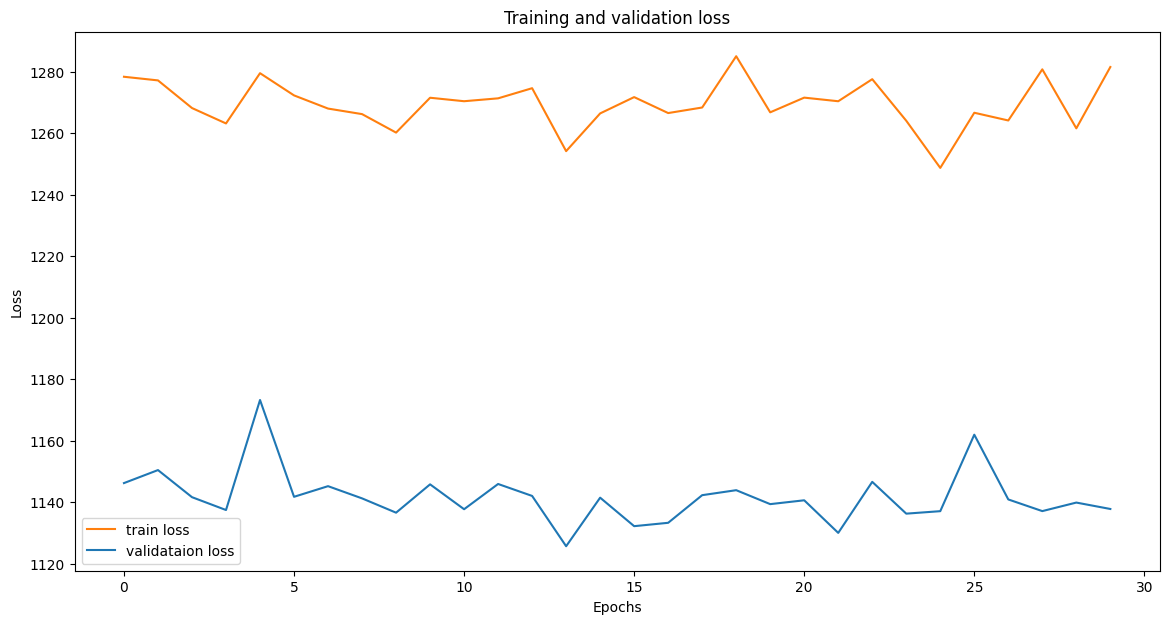

In [62]:
# Plotting the train and validation loss graphs

fig_1 = plt.figure(figsize=(14, 7))
plt.plot(train_loss, 'tab:orange', label='train loss')
plt.plot(valid_loss, 'tab:blue', label='validataion loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc ='best')
plt.show()

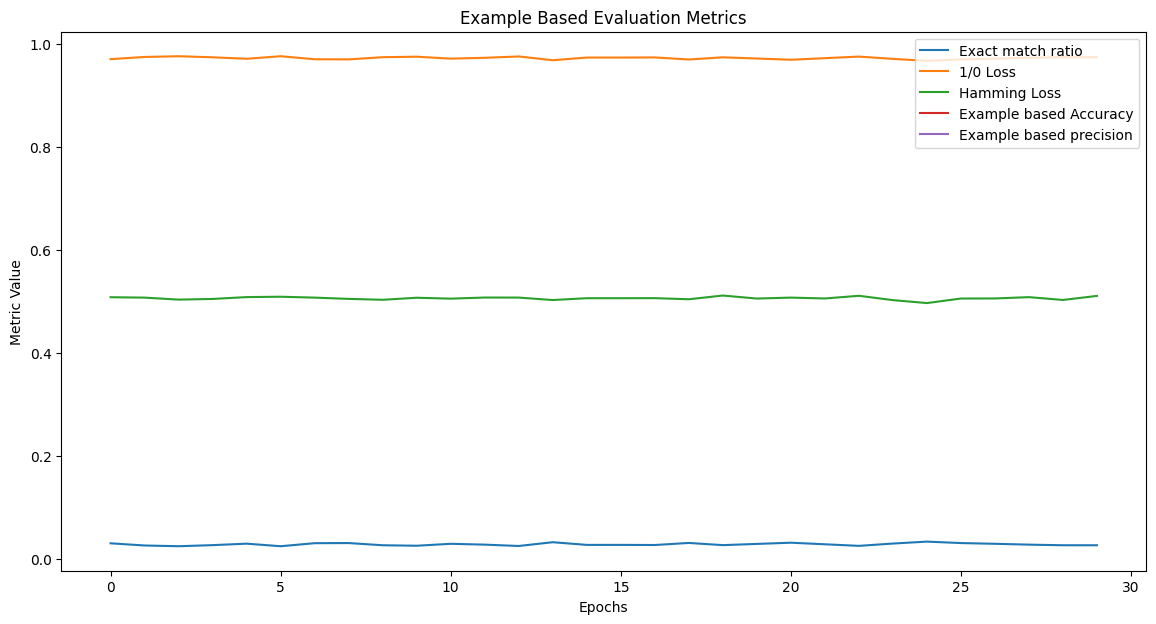

In [63]:
fig_2 = plt.figure(figsize = (14, 7))
plt.plot(emr_list, 'tab:blue', label='Exact match ratio')
plt.plot(one_zero_loss_list, 'tab:orange', label='1/0 Loss')
plt.plot(hamming_loss_list, 'tab:green', label='Hamming Loss')
plt.plot(example_based_accuracy_list, 'tab:red', label='Example based Accuracy')
plt.plot(example_based_precision_list, 'tab:purple', label='Example based precision')
plt.title('Example Based Evaluation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend(loc ='best')
plt.show()

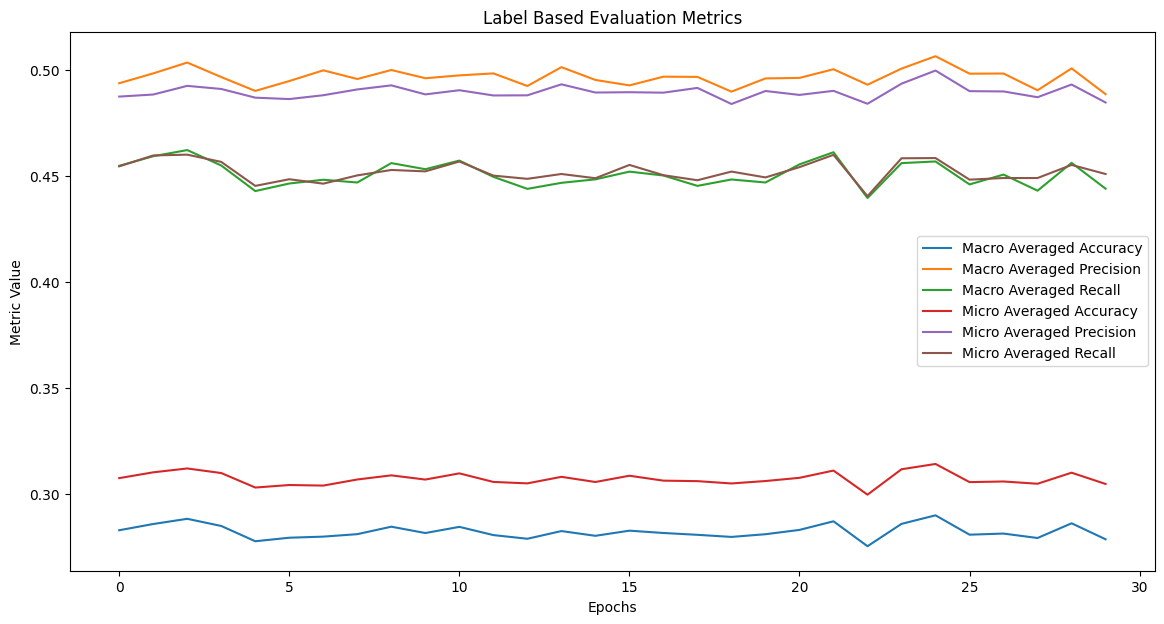

In [64]:
fig_3 = plt.figure(figsize = (14, 7))
plt.plot(label_based_macro_accuracy_list, 'tab:blue', label='Macro Averaged Accuracy')
plt.plot(label_based_macro_precision_list, 'tab:orange', label='Macro Averaged Precision')
plt.plot(label_based_macro_recall_list, 'tab:green', label='Macro Averaged Recall')
plt.plot(label_based_micro_accuracy_list, 'tab:red', label='Micro Averaged Accuracy')
plt.plot(label_based_micro_precision_list, 'tab:purple', label='Micro Averaged Precision')
plt.plot(label_based_micro_recall_list, 'tab:brown', label='Micro Averaged Recall')
# plt.plot(f1_score_list, 'tab:gray', label='F1 Score')
plt.title('Label Based Evaluation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend(loc ='best')
plt.show()